Blood Group Detection from Fingerprint using VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the required libraries

In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

Download and unzip the dataset

In [3]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
finger-print-based-blood-group-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

Data preprocessing

In [5]:
file_path = '/content/dataset_blood_group'

In [6]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

Splitting the dataset into train and test sets

In [7]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

Image data augmentation

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


Model architecture

In [9]:
pretrained_model = VGG16(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

In [10]:
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,137,480 (88.26 MB)

 Trainable params: 8,422,792 (32.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model training

In [11]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 339ms/step - accuracy: 0.6378 - loss: 7.3204 - val_accuracy: 0.7800 - val_loss: 1.6769
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.8671 - loss: 0.6905 - val_accuracy: 0.8333 - val_loss: 0.8204
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 266ms/step - accuracy: 0.9522 - loss: 0.1625 - val_accuracy: 0.8400 - val_loss: 0.8848
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.9695 - loss: 0.1181 - val_accuracy: 0.8508 - val_loss: 0.8421
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9740 - loss: 0.0896 - val_accuracy: 0.8475 - val_loss: 1.0520
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9794 - loss: 0.0743 - val_accuracy: 0.8600 - val_loss: 1.1435
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9803 - loss: 0.0809 - val_accuracy: 0.8550 - val_loss: 1.0958
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9733 - loss: 0

Saving the model

In [12]:
model.save("vgg16.keras")

Model evaluation

In [13]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step
              precision    recall  f1-score   support

          A+       0.93      0.85      0.89       113
          A-       0.84      0.81      0.83       202
         AB+       0.84      0.92      0.88       142
         AB-       0.75      0.89      0.82       152
          B+       0.89      0.85      0.87       130
          B-       0.96      0.80      0.88       148
          O+       0.87      0.81      0.84       171
          O-       0.77      0.86      0.81       142

    accuracy                           0.85      1200
   macro avg       0.86      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



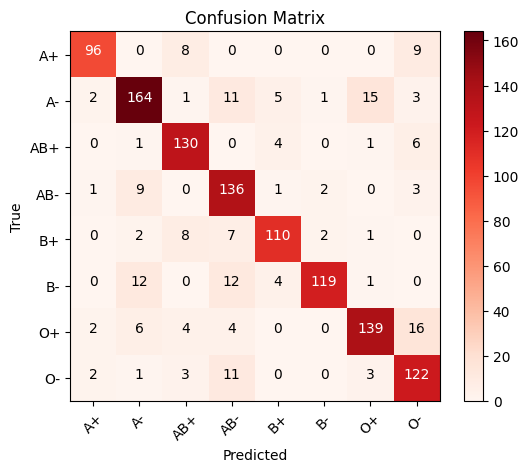

In [14]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Visualizing accuracy and loss over epochs

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

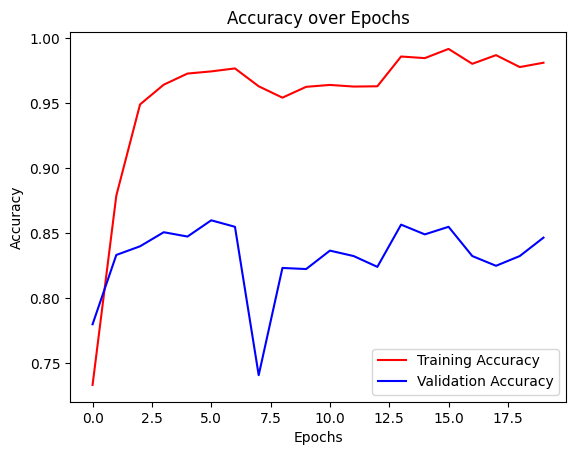

In [16]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

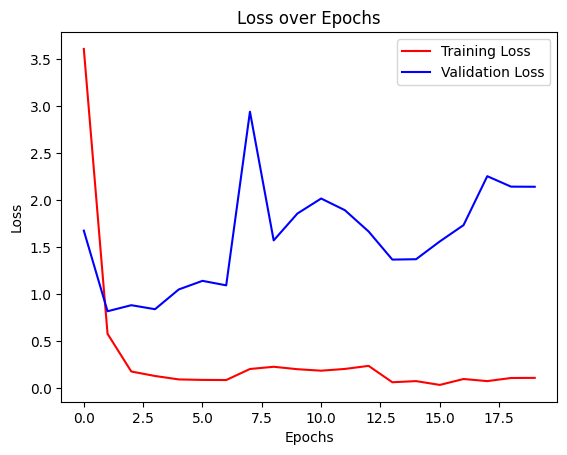

In [17]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model prediction

In [27]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


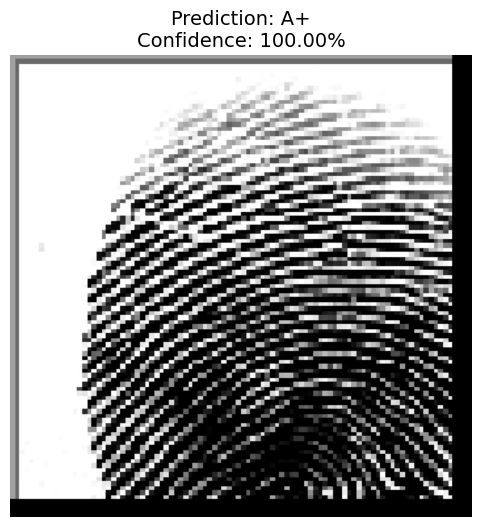

In [28]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


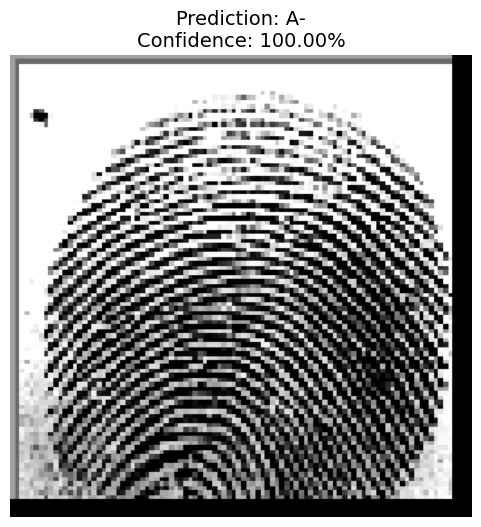

In [29]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


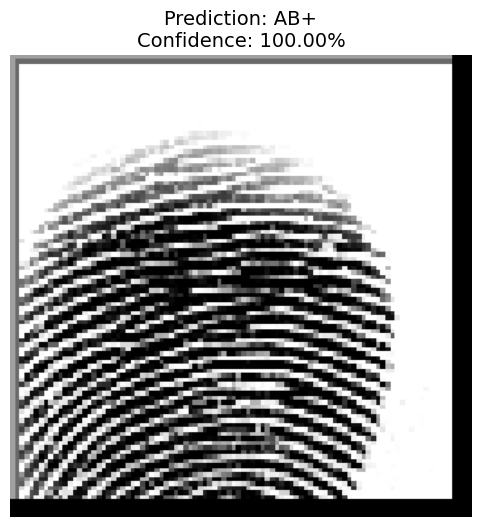

In [30]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


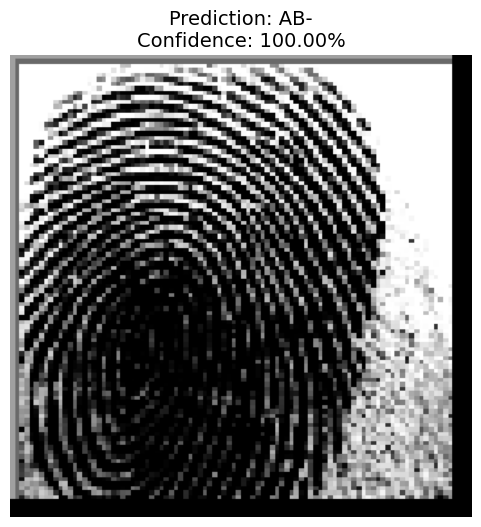

In [31]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1013.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


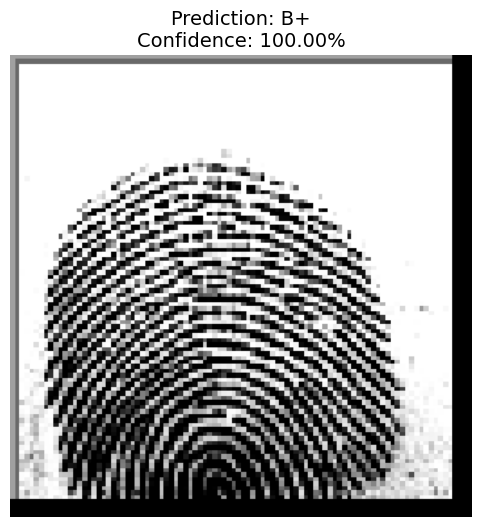

In [32]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


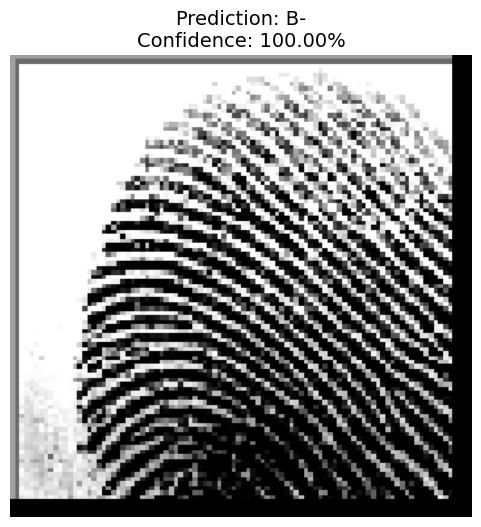

In [33]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


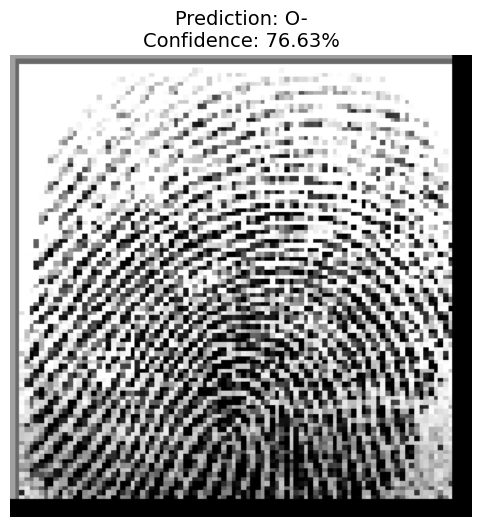

In [34]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


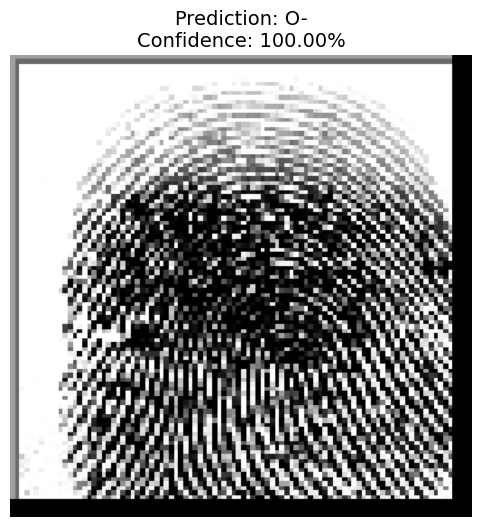

In [35]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1028.BMP'
predict_blood_group(image_path, model, class_names)